# CIFAR10 with CNNs
Simple starter notebook to benchmark your own CNN with PyTorch on the CIFAR-10 dataset.

OBS.:

- The main code is basically done, so focus on training the models and searching for the best hyperparameters and architectures.
- You are not required to use this exact code or even the PyTorch library.
- It is recommended to use execution environments with GPU access (such as Google Colab), since larger models will take more time to train.
- Remember to document the history of your experiments and which results motivated the changes in subsequent experiments.

In [18]:
#@title Libs

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

In [3]:
#@title Dataset Setup

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


## 1. Exploração dos Dados


Nesta etapa, realizamos uma análise exploratória do conjunto CIFAR-10, com o objetivo de entender suas características visuais e verificar o balanceamento das classes.



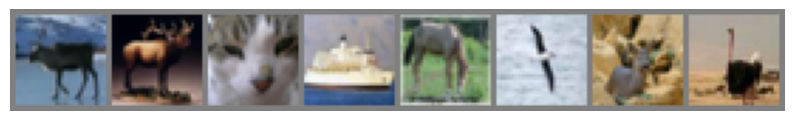

Labels: ['deer', 'deer', 'cat', 'ship', 'horse', 'bird', 'deer', 'bird']


In [19]:
classes = train_dataset.classes

# Função para mostrar imagens
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Mostrar algumas imagens
loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
dataiter = iter(loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', [classes[label] for label in labels[:8]])

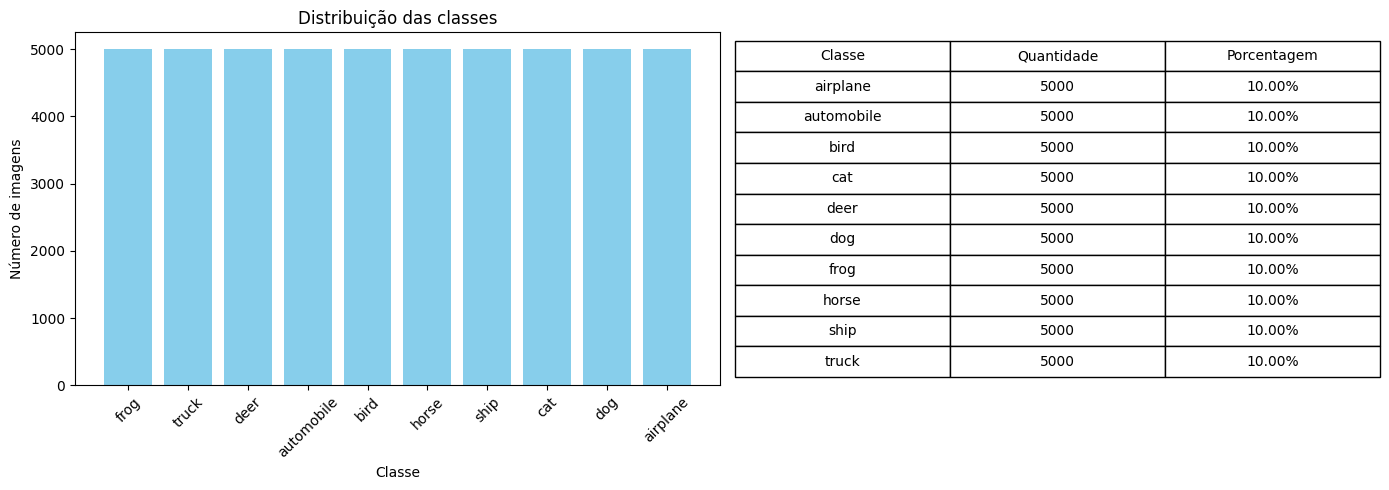

In [21]:

# Contagem de imagens por classe
class_counts = {}
for _, label in train_dataset:
    class_name = classes[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

total_images = len(train_dataset)

# Criar DataFrame com a distribuição
df_distribution = pd.DataFrame([
    {"Classe": cls, "Quantidade": count, "Porcentagem": f"{(count / total_images) * 100:.2f}%"}
    for cls, count in class_counts.items()
])

# Mostrar tabela ordenada por classe
df_distribution = df_distribution.sort_values("Classe").reset_index(drop=True)

# Criar gráfico e tabela lado a lado
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axs[0].bar(class_counts.keys(), class_counts.values(), color='skyblue')
axs[0].set_title("Distribuição das classes")
axs[0].set_xlabel("Classe")
axs[0].set_ylabel("Número de imagens")
axs[0].tick_params(axis='x', rotation=45)

# Tabela
axs[1].axis('off')
table = axs[1].table(cellText=df_distribution.values,
                     colLabels=df_distribution.columns,
                     cellLoc='center',
                     loc='center')
table.scale(1, 2)  # ajustar tamanho

plt.tight_layout()
plt.show()


Pode-se observar que os dados estão perfeitamente balanceados, com exatamente 10% das imagens atribuídas a cada uma das dez classes. Esse equilíbrio entre as classes é favorável, pois garante que o modelo não será tendencioso para nenhuma categoria específica. Dessa forma, podemos focar na análise do desempenho da arquitetura da rede neural em si, sem que a qualidade do conjunto de dados comprometa os resultados dos experimentos.

## 2. Experimento 1 — Aprofundamento da CNN com Regularização

Neste experimento, buscamos aumentar a capacidade da rede e reduzir o overfitting adicionando camadas adicionais e técnicas de regularização (Dropout e BatchNorm). Além disso, aumentamos o número de épocas pra 20




In [6]:
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x)


In [8]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [31]:
#@title Hyperparameters

learning_rate = 0.001
num_epochs = 20
batch_size = 32

loss_function = nn.CrossEntropyLoss()

In [32]:
#@title Loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
#@title Training loop

# Build the model
cnn = DeepCNN()
cnn.cuda()

# Setting optimizer up
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Early stopping setup
best_loss = float('inf')
patience = 5
patience_counter = 0

loss_epoch = []
accuracy_epoch = []

# Start training epochs loop
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    correct = 0
    total = 0

    cnn.train()  # coloca em modo treino

    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        # Forward pass
        optimizer.zero_grad()
        outputs = cnn(images)

        # Cálculo da loss
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calcular acurácia (durante treino mesmo)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 1000 == 0:
            tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_loader)}, Loss: {loss:.4f}')

    # Calcular média da loss e acurácia
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total

    loss_epoch.append(avg_loss)
    accuracy_epoch.append(accuracy)

    tqdm.write(f'Epoch {epoch + 1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("Early stopping triggered.")
            break

  0%|          | 0/20 [00:12<?, ?it/s]

Epoch 1/20, Step 1000/1563, Loss: 1.2718


  5%|▌         | 1/20 [00:19<06:07, 19.36s/it]

Epoch 1 - Loss: 1.7326, Accuracy: 35.74%


  5%|▌         | 1/20 [00:33<06:07, 19.36s/it]

Epoch 2/20, Step 1000/1563, Loss: 1.4074


 10%|█         | 2/20 [00:42<06:24, 21.36s/it]

Epoch 2 - Loss: 1.4257, Accuracy: 48.21%


 10%|█         | 2/20 [00:53<06:24, 21.36s/it]

Epoch 3/20, Step 1000/1563, Loss: 1.3968


 15%|█▌        | 3/20 [01:00<05:40, 20.03s/it]

Epoch 3 - Loss: 1.3059, Accuracy: 53.00%


 15%|█▌        | 3/20 [01:12<05:40, 20.03s/it]

Epoch 4/20, Step 1000/1563, Loss: 1.3794


 20%|██        | 4/20 [01:19<05:11, 19.49s/it]

Epoch 4 - Loss: 1.2331, Accuracy: 56.22%


 20%|██        | 4/20 [01:31<05:11, 19.49s/it]

Epoch 5/20, Step 1000/1563, Loss: 1.2803


 25%|██▌       | 5/20 [01:37<04:46, 19.10s/it]

Epoch 5 - Loss: 1.1682, Accuracy: 58.53%


 25%|██▌       | 5/20 [01:49<04:46, 19.10s/it]

Epoch 6/20, Step 1000/1563, Loss: 1.1221


 30%|███       | 6/20 [01:56<04:24, 18.93s/it]

Epoch 6 - Loss: 1.1111, Accuracy: 60.85%


 30%|███       | 6/20 [02:08<04:24, 18.93s/it]

Epoch 7/20, Step 1000/1563, Loss: 1.4509


 35%|███▌      | 7/20 [02:14<04:02, 18.66s/it]

Epoch 7 - Loss: 1.0683, Accuracy: 62.08%


 35%|███▌      | 7/20 [02:26<04:02, 18.66s/it]

Epoch 8/20, Step 1000/1563, Loss: 0.9861


 40%|████      | 8/20 [02:33<03:46, 18.85s/it]

Epoch 8 - Loss: 1.0216, Accuracy: 63.76%


 40%|████      | 8/20 [02:45<03:46, 18.85s/it]

Epoch 9/20, Step 1000/1563, Loss: 0.9992


 45%|████▌     | 9/20 [02:51<03:24, 18.60s/it]

Epoch 9 - Loss: 0.9962, Accuracy: 64.68%


 45%|████▌     | 9/20 [03:03<03:24, 18.60s/it]

Epoch 10/20, Step 1000/1563, Loss: 1.1475


 50%|█████     | 10/20 [03:10<03:05, 18.59s/it]

Epoch 10 - Loss: 0.9529, Accuracy: 66.41%


 50%|█████     | 10/20 [03:22<03:05, 18.59s/it]

Epoch 11/20, Step 1000/1563, Loss: 0.9203


 55%|█████▌    | 11/20 [03:28<02:46, 18.50s/it]

Epoch 11 - Loss: 0.9079, Accuracy: 67.94%


 55%|█████▌    | 11/20 [03:40<02:46, 18.50s/it]

Epoch 12/20, Step 1000/1563, Loss: 0.7917


 60%|██████    | 12/20 [03:47<02:28, 18.55s/it]

Epoch 12 - Loss: 0.8778, Accuracy: 69.08%


 60%|██████    | 12/20 [03:59<02:28, 18.55s/it]

Epoch 13/20, Step 1000/1563, Loss: 0.8404


 65%|██████▌   | 13/20 [04:05<02:09, 18.52s/it]

Epoch 13 - Loss: 0.8545, Accuracy: 69.85%


 65%|██████▌   | 13/20 [04:17<02:09, 18.52s/it]

Epoch 14/20, Step 1000/1563, Loss: 0.5633


 70%|███████   | 14/20 [04:24<01:51, 18.53s/it]

Epoch 14 - Loss: 0.8178, Accuracy: 71.30%


 70%|███████   | 14/20 [04:35<01:51, 18.53s/it]

Epoch 15/20, Step 1000/1563, Loss: 0.6021


 75%|███████▌  | 15/20 [04:42<01:31, 18.36s/it]

Epoch 15 - Loss: 0.7948, Accuracy: 71.86%


 75%|███████▌  | 15/20 [04:53<01:31, 18.36s/it]

Epoch 16/20, Step 1000/1563, Loss: 0.9911


 80%|████████  | 16/20 [05:00<01:13, 18.39s/it]

Epoch 16 - Loss: 0.7723, Accuracy: 72.77%


 80%|████████  | 16/20 [05:12<01:13, 18.39s/it]

Epoch 17/20, Step 1000/1563, Loss: 0.5421


 85%|████████▌ | 17/20 [05:18<00:54, 18.24s/it]

Epoch 17 - Loss: 0.7397, Accuracy: 73.98%


 85%|████████▌ | 17/20 [05:30<00:54, 18.24s/it]

Epoch 18/20, Step 1000/1563, Loss: 0.9417


 90%|█████████ | 18/20 [05:37<00:36, 18.36s/it]

Epoch 18 - Loss: 0.7235, Accuracy: 74.38%


 90%|█████████ | 18/20 [05:48<00:36, 18.36s/it]

Epoch 19/20, Step 1000/1563, Loss: 1.1357


 95%|█████████▌| 19/20 [05:55<00:18, 18.26s/it]

Epoch 19 - Loss: 0.7076, Accuracy: 75.02%


 95%|█████████▌| 19/20 [06:06<00:18, 18.26s/it]

Epoch 20/20, Step 1000/1563, Loss: 0.4061


100%|██████████| 20/20 [06:13<00:00, 18.68s/it]

Epoch 20 - Loss: 0.6826, Accuracy: 75.90%


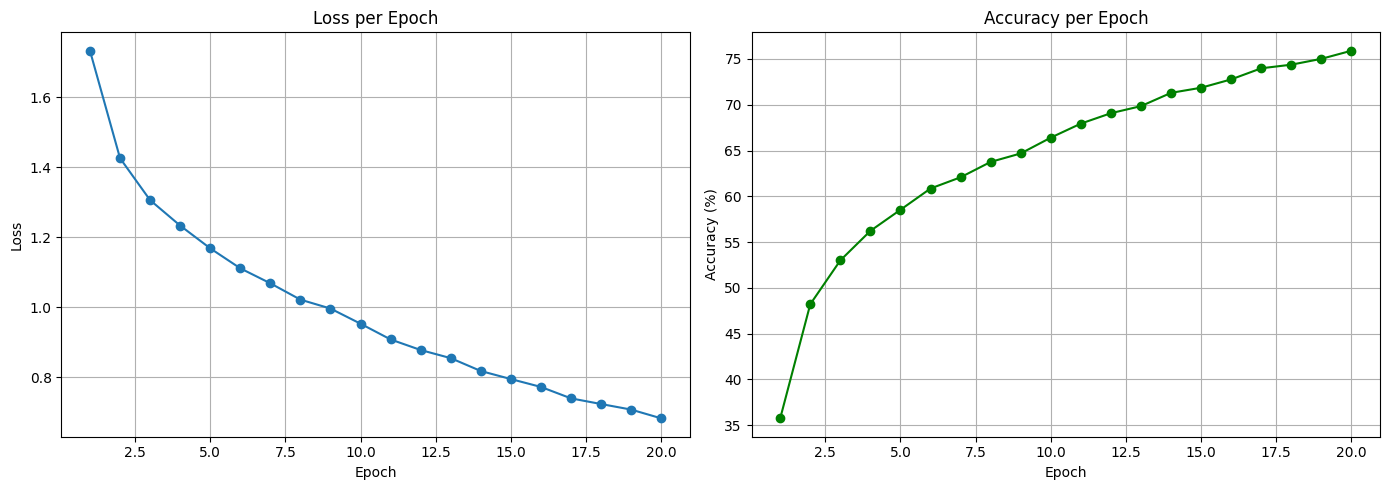

Accuracy of the network on the 10000 test images: 74.63%


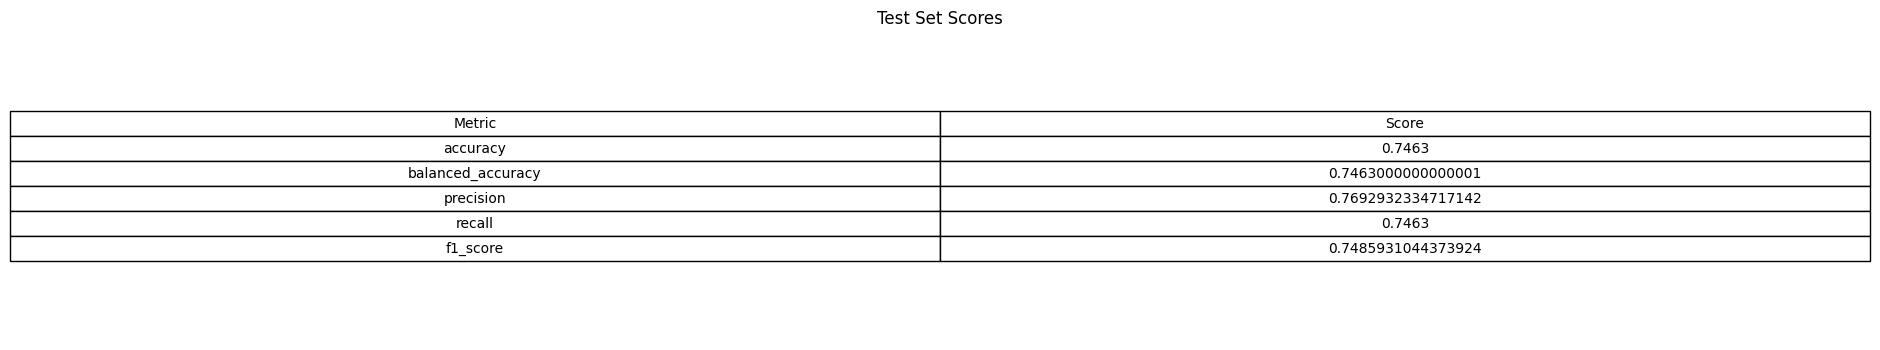

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axs[0].plot(range(1, len(loss_epoch) + 1), loss_epoch, marker='o')
axs[0].set_title('Loss per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid(True)

# Plot Accuracy
axs[1].plot(range(1, len(accuracy_epoch) + 1), accuracy_epoch, marker='o', color='green')
axs[1].set_title('Accuracy per Epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model on the test dataset
cnn.eval()  # Put the model in evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f}%')

# Get detailed scores
scores = get_scores(all_targets, all_predictions)

# Create a table for the scores
df_scores = pd.DataFrame([scores])
df_scores = df_scores.T.reset_index()
df_scores.columns = ['Metric', 'Score']

# Display table with matplotlib for side-by-side view if desired (optional)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.axis('off')
table = ax.table(cellText=df_scores.values,
                 colLabels=df_scores.columns,
                 cellLoc='center',
                 loc='center')
table.scale(3, 1.5)
plt.title("Test Set Scores")
plt.show()